In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import embedders

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

# Filter out warnings raised when sampling Wishart distribution in Gaussian mixtures
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if device != torch.device("cuda"):
    sample_device = torch.device("cpu")
else:
    sample_device = device

print(f"Device: {device}, Sample Device: {sample_device}")

Device: cuda, Sample Device: cuda


# Shared hyperparameters

In [ ]:
N_FEATURES = "d_choose_2"
MAX_DEPTH = 3
MODELS = ["product_dt", "product_rf", "tangent_mlp", "ambient_mlp", "tangent_gnn", "ambient_gnn"]
N_SAMPLES = 10

DOWNSAMPLE = 1000  # Used when number of datapoints per dataset is too large to work with

In [5]:
# Quick test hyperparameters

# N_SAMPLES = 1
# DOWNSAMPLE = 10

# Single curvature

In [ ]:
CURVATURES = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_POINTS = 1_000
N_CLASSES = 8
N_CLUSTERS = 32
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 1.0

RESAMPLE_SCALES = False

# SCORE = "f1-micro" if TASK == "classification" else "rmse"

for TASK in ["classification", "regression"]:
    results = []
    SCORE = ["f1-micro", "accuracy"] if TASK == "classification" else ["rmse"]
    my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
    for i, K in enumerate(CURVATURES):
        for seed in range(N_SAMPLES):
            try:
                # Ensure unique seed per trial
                seed = seed + N_SAMPLES * i
                pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)]).to(sample_device)

                # Get X, y
                X, y = embedders.gaussian_mixture.gaussian_mixture(
                    pm=pm,
                    seed=seed,
                    num_points=N_POINTS,
                    num_classes=N_CLASSES,
                    num_clusters=N_CLUSTERS,
                    cov_scale_means=COV_SCALE_MEANS / DIM,
                    cov_scale_points=COV_SCALE_POINTS / DIM,
                    task=TASK,
                )
                X = X.to(device)
                y = y.to(device)
                pm = pm.to(device)

                model_results = embedders.benchmarks.benchmark(
                    X,
                    y,
                    pm,
                    max_depth=MAX_DEPTH,
                    task=TASK,
                    score=SCORE,
                    seed=seed,
                    n_features=N_FEATURES,
                    device=device,
                    models=MODELS,
                )

                model_results["curvature"] = K
                model_results["seed"] = seed

                # Flatten the nested model results
                for model, metrics in model_results.items():
                    for metric, value in metrics.items():
                        run_results[f"{model}_{metric}"] = value

                results.append(run_results)
            except Exception as e:
                print(f"Error: {e}")
            my_tqdm.update(1)

    # Convert to DataFrame
    results = pd.DataFrame(results)

    results.to_csv(f"embedders/data/results/{TASK}_nn_single_curvature.tsv", sep="\t", index=False)

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Error: Input contains NaN.
Error: Input contains NaN.


# Multiple curvatures

In [ ]:
# Multiple curvatures

# Signatures - using non-Gu approach for now
SIGNATURES = [
    [(-1, 2), (-1, 2)],  # HH
    [(-1, 2), (0, 2)],  # HE
    [(-1, 2), (1, 2)],  # HS
    [(1, 2), (1, 2)],  # SS
    [(1, 2), (0, 2)],  # SE
    [(-1, 4)],  # H
    [(0, 4)],  # E
    [(1, 4)],  # S
]

SIGNATURES_STR = ["HH", "HE", "HS", "SS", "SE", "H", "E", "S"]

DIM = 4
N_POINTS = 1_000
N_CLASSES = 8
N_CLUSTERS = 32
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 1.0

for TASK in ["classification", "regression"]:
    results = []
    SCORE = ["f1-micro", "accuracy"] if TASK == "classification" else ["rmse"]

    my_tqdm = tqdm(total=len(SIGNATURES) * N_SAMPLES)
    for i, (sig, sigstr) in enumerate(zip(SIGNATURES, SIGNATURES_STR)):
        for seed in range(N_SAMPLES):
            try:
                # Ensure unique seed per trial
                seed = seed + N_SAMPLES * i
                pm = embedders.manifolds.ProductManifold(signature=sig, device=sample_device)

                # Get X, y
                X, y = embedders.gaussian_mixture.gaussian_mixture(
                    pm=pm,
                    seed=seed,
                    num_points=N_POINTS,
                    num_classes=N_CLASSES,
                    num_clusters=N_CLUSTERS,
                    cov_scale_means=COV_SCALE_MEANS / DIM,
                    cov_scale_points=COV_SCALE_POINTS / DIM,
                    task=TASK,
                )
                X = X.to(device)
                y = y.to(device)
                pm = pm.to(device)

                if RESAMPLE_SCALES:
                    scale = 0.5 - np.random.rand() * 20
                    pm.P[0].scale = torch.exp(torch.tensor(scale)).item()
                    pm.P[0].manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

                # Benchmarks are now handled by the benchmark function
                model_results = embedders.benchmarks.benchmark(
                    X,
                    y,
                    pm,
                    max_depth=MAX_DEPTH,
                    task=TASK,
                    score=SCORE,
                    seed=seed,
                    n_features=N_FEATURES,
                    device=device,
                )

                # Create a flat dictionary for this run
                run_results = {"signature": sigstr, "seed": seed}

                # Flatten the nested model results
                for model, metrics in model_results.items():
                    for metric, value in metrics.items():
                        run_results[f"{model}_{metric}"] = value

                results.append(run_results)
            except Exception as e:
                print(f"Error: {e}")
            my_tqdm.update(1)

    results = pd.DataFrame(results)

    results.to_csv(f"embedders/data/results/{TASK}_nn_multiple_curvatures.tsv", sep="\t", index=False)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

# Graph embeddings - known matrix

In [8]:
GRAPHS = [
    ("citeseer", "HS", [(-1, 2), (1, 2)], "classification"),
    ("cora", "H", [(-1, 4)], "classification"),
    ("polblogs", "SS", [(1, 2), (1, 2)], "classification"),
    ("cs_phds", "H", [(-1, 4)], "regression"),
]

results = []
my_tqdm = tqdm(total=len(GRAPHS) * N_SAMPLES)
for embedding, sigstr, sig, task in GRAPHS:
    _, y, adj = embedders.dataloaders.load(embedding)
    adj = adj.to(device).float().detach()
    pm = embedders.manifolds.ProductManifold(signature=sig, device=device)

    for i in range(N_SAMPLES):
        try:
            X = torch.tensor(np.load(f"embedders/data/graphs/embeddings/{embedding}/{sigstr}_{i}.npy"), device=device)
            score = ["f1-micro", "accuracy"] if task == "classification" else ["rmse"]

            model_results = embedders.benchmarks.benchmark(
                X,
                y,
                pm,
                max_depth=MAX_DEPTH,
                n_features=N_FEATURES,
                seed=i,
                device=device,
                adj=adj,
                models=MODELS,
                task=task,
                score=score,
            )

            # Create a flat dictionary for this run
            run_results = {"embedding": embedding, "seed": i}

            # Flatten the nested model results
            for model, metrics in model_results.items():
                for metric, value in metrics.items():
                    run_results[f"{model}_{metric}"] = value

            results.append(run_results)
        except Exception as e:
            print(f"Error: {e}")
        my_tqdm.update(1)

results = pd.DataFrame(results)
results.to_csv(f"embedders/data/results/all_nn_graph.tsv", sep="\t", index=False)

  0%|          | 0/40 [00:00<?, ?it/s]

Top CC has 2110 nodes; original graph has 3264 nodes.


Top CC has 2485 nodes; original graph has 2708 nodes.
Top CC has 1222 nodes; original graph has 1490 nodes.
Top CC has 1025 nodes; original graph has 1025 nodes.


# VAE latents

In [ ]:
import numpy as np
import embedders
import pandas as pd
from tqdm.notebook import tqdm

embeddings_names = [
    "blood_cell_scrna",
    "lymphoma",
    "cifar_100",
    "mnist",
]
sigs = [
    [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2)],
    [(1, 2), (0, 2), (-1, 2)],
]
sets = ["train", "test"]
datasets = ["X", "y"]

# bad = []
# for embedding in embeddings_names:
#     for trial in range(n_trials):
#         for set_name in sets:
#             for dataset in datasets:
#                 my_data = np.load(f"../data/{embedding}/embeddings/{dataset}_{set_name}_{trial}.npy")
#                 if np.isnan(my_data).any():
#                     bad.append((embedding, trial, set_name, dataset))
#                     print(embedding, trial, set_name, dataset)
#                 # print(my_data.shape)
# print(bad)

results = []
my_tqdm = tqdm(total=len(embeddings_names) * N_SAMPLES)
for embedding, sig in zip(embeddings_names, sigs):
    pm = embedders.manifolds.ProductManifold(signature=sig)
    for trial in range(N_SAMPLES):
        # try:
        X_train = np.load(f"embedders/data/{embedding}/embeddings/X_train_{trial}.npy")
        y_train = np.load(f"embedders/data/{embedding}/embeddings/y_train_{trial}.npy")
        X_test = np.load(f"embedders/data/{embedding}/embeddings/X_test_{trial}.npy")
        y_test = np.load(f"embedders/data/{embedding}/embeddings/y_test_{trial}.npy")

        # Convert to torch tensors
        X_train = torch.tensor(X_train, device=device)
        y_train = torch.tensor(y_train, device=device)
        X_test = torch.tensor(X_test, device=device)
        y_test = torch.tensor(y_test, device=device)

        # Randomly subsample
        if len(X_train) > DOWNSAMPLE:
            idx = np.random.choice(X_train.shape[0], DOWNSAMPLE, replace=False)
            X_train = X_train[idx]
            y_train = y_train[idx]

        if len(X_test) > DOWNSAMPLE:
            idx = np.random.choice(X_test.shape[0], DOWNSAMPLE, replace=False)
            X_test = X_test[idx]
            y_test = y_test[idx]

        model_results = embedders.benchmarks.benchmark(
            X=None,
            y=None,
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            pm=pm,
            # models=["sklearn_dt", "product_dt"],
            max_depth=MAX_DEPTH,
            batch_size=1,
            n_features=N_FEATURES,
            models=MODELS,
            task="classification",
            score=["f1-micro", "accuracy"],
            device=device,
        )
        # res["embedding"] = embedding
        # res["trial"] = trial

        # results.append(res)
        # my_tqdm.update(1)

        run_results = {"embedding": embedding, "seed": trial}

        # Flatten the nested model results
        for model, metrics in model_results.items():
            for metric, value in metrics.items():
                run_results[f"{model}_{metric}"] = value

        results.append(run_results)
        # except Exception as e:
        # print(f"Error: {e}")
        my_tqdm.update(1)

results = pd.DataFrame(results)
results.to_csv(f"embedders/data/results/all_nn_vae.tsv", sep="\t", index=False)

  0%|          | 0/40 [00:00<?, ?it/s]

# Empirical

In [61]:
from tqdm.notebook import tqdm
import embedders
import pandas as pd

N_SAMPLES = 10
# N_SAMPLES = 1
DEVICE = "cuda"
DOWNSAMPLE = 1_000

# my_tqdm = tqdm(total=5 * N_SAMPLES)
my_tqdm = tqdm(total=5 * N_SAMPLES)

results = []
for dataset, signature, objective in zip(
    ["landmasses", "neuron_33", "neuron_46", "temperature", "traffic"],
    [[(1, 2)], [(1, 1)] * 10, [(1, 1)] * 10, [(1, 2), (1, 1)], [(0, 1)] + [(1, 1)] * 4],
    ["classification", "classification", "classification", "regression", "regression"],
    # ["neuron_33", "neuron_46"],#, "temperature", "traffic"],
    # [[(1, 1)] * 10, [(1, 1)] * 10],#, [(1, 2), (1, 1)], [(0, 1)] + [(1, 1)] * 4],
    # ["classification", "classification"],#, "regression", "regression"],
):
    score = ["f1-micro", "accuracy"] if objective == "classification" else ["rmse"]
    pm = embedders.manifolds.ProductManifold(signature=signature, device=DEVICE)

    for seed in range(N_SAMPLES):
        # try:
        X, y, _ = embedders.dataloaders.load(dataset, seed=seed)
        # Resample
        if len(X) > DOWNSAMPLE:
            random_sample = np.random.choice(X.shape[0], DOWNSAMPLE, replace=False)
            X = X[random_sample]
            y = y[random_sample]
        model_results = embedders.benchmarks.benchmark(
            X=X,
            y=y,
            pm=pm,
            # max_depth=MAX_DEPTH,
            # n_features=N_FEATURES,
            seed=seed,
            # device=device,
            # models=MODELS,
            task=objective,
            score=score,
            device=DEVICE
        )

        # Create a flat dictionary for this run
        # run_results = {"dataset": dataset, "seed": 0}
        model_results["dataset"] = dataset
        model_results["seed"] = seed

            # # Flatten the nested model results
            # for model, metrics in model_results.items():
            #     for metric, value in metrics.items():
            #         run_results[f"{model}_{metric}"] = value

        results.append(model_results)
        print(results)
        # except Exception as e:
            # print(f"Error: {e}")
        my_tqdm.update(1)

results = pd.DataFrame(results)
# results.to_csv(f"../data/results_icml/all_nn_empirical.tsv", sep="\t", index=False)
results.to_csv(f"../data/results_icml/all_nn_neurons.tsv", sep="\t", index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[{'sklearn_dt_f1-micro': 0.835, 'sklearn_dt_accuracy': 0.835, 'sklearn_dt_time': 0.0014612674713134766, 'sklearn_rf_f1-micro': 0.875, 'sklearn_rf_accuracy': 0.875, 'sklearn_rf_time': 0.03629469871520996, 'product_dt_f1-micro': 0.895, 'product_dt_accuracy': 0.895, 'product_dt_time': 0.0312800407409668, 'product_rf_f1-micro': 0.925, 'product_rf_accuracy': 0.925, 'product_rf_time': 0.3361194133758545, 'tangent_dt_f1-micro': 0.865, 'tangent_dt_accuracy': 0.865, 'tangent_dt_time': 0.0011529922485351562, 'tangent_rf_f1-micro': 0.885, 'tangent_rf_accuracy': 0.885, 'tangent_rf_time': 0.03367900848388672, 'knn_f1-micro': 0.95, 'knn_accuracy': 0.95, 'knn_time': 0.002261638641357422, 'ps_perceptron_f1-micro': 0.76, 'ps_perceptron_accuracy': 0.76, 'ps_perceptron_time': 0.0033996105194091797, 'ambient_mlp_f1-micro': 0.715, 'ambient_mlp_accuracy': 0.715, 'ambient_mlp_time': 34.14513611793518, 'ambient_gnn_f1-micro': 0.75, 'ambient_gnn_accuracy': 0.75, 'ambient_gnn_time': 42.22631525993347, 'kappa_gc

In [56]:
pm.signature

[(1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1)]

# Link prediction

In [5]:
# Special function to split dataset while ensuring pairs are in the same split
from sklearn.model_selection import train_test_split


def split_dataset(X, y, **kwargs):
    n_pairs, n_dims = X.shape
    n_nodes = int(n_pairs**0.5)

    # Reshape
    X_reshaped = X.view(n_nodes, n_nodes, -1)
    y_reshaped = y.view(n_nodes, n_nodes)

    # Take 20% Of the nodes as test nodes
    idx = list(range(n_nodes))
    idx_train, idx_test = train_test_split(idx, **kwargs)

    # Return test and train sets
    X_train = X_reshaped[idx_train][:, idx_train].reshape(-1, n_dims)
    y_train = y_reshaped[idx_train][:, idx_train].reshape(-1)

    X_test = X_reshaped[idx_test][:, idx_test].reshape(-1, n_dims)
    y_test = y_reshaped[idx_test][:, idx_test].reshape(-1)

    return X_train, X_test, y_train, y_test

In [ ]:
# Karate club
USE_DISTS = True
SIGNATURE = [(1, 2), (0, 2), (-1, 2)]
TOTAL_ITERATIONS = 1_000

results = []
my_tqdm = tqdm(total=N_SAMPLES * 6)

for dataset in ["adjnoun", "dolphins", "football", "karate_club", "lesmis", "polbooks"]:
    dists, labels, adj = embedders.dataloaders.load(dataset)
    dists = dists / dists.max()

    results_dataset = []
    i = -1
    while len(results_dataset) < N_SAMPLES:
        i += 1
        pm = embedders.manifolds.ProductManifold(signature=SIGNATURE)
        try:
            X_embed, losses = embedders.coordinate_learning.train_coords(
                pm,
                dists,
                burn_in_iterations=int(0.1 * TOTAL_ITERATIONS),
                training_iterations=int(0.9 * TOTAL_ITERATIONS),
                scale_factor_learning_rate=0.02,
            )
            assert not torch.isnan(X_embed).any()

            X, y, pm_new = embedders.link_prediction.make_link_prediction_dataset(X_embed, pm, adj, add_dists=USE_DISTS)
            X = X.to(device).detach()
            y = y.to(device).detach()
            X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.2, random_state=i)
            if len(X_train) > DOWNSAMPLE:
                idx = np.random.choice(X_train.shape[0], DOWNSAMPLE, replace=False)
                X_train = X_train[idx]
                y_train = y_train[idx]
            if len(X_test) > DOWNSAMPLE:
                idx = np.random.choice(X_test.shape[0], DOWNSAMPLE, replace=False)
                X_test = X_test[idx]
                y_test = y_test[idx]

            model_results = embedders.benchmarks.benchmark(
                X=None,
                y=None,
                X_train=X_train,
                X_test=X_test,
                y_train=y_train,
                y_test=y_test,
                pm=pm_new,
                max_depth=MAX_DEPTH,
                task="classification",
                n_features=N_FEATURES,
                models=MODELS,
                device=device,
            )
            # model_results = embedders.benchmarks.benchmark(
            #     X, y, pm_new, max_depth=MAX_DEPTH, task="classification", score=["f1-micro", "accuracy"], device=device, models=MODELS, n_features=N_FEATURES,
            #     batch_size=1
            # )
            # Create a flat dictionary for this run
            run_results = {"dataset": dataset, "seed": i}

            # Flatten the nested model results
            for model, metrics in model_results.items():
                for metric, value in metrics.items():
                    run_results[f"{model}_{metric}"] = value

            results_dataset.append(run_results)

        except ValueError as e:
            print(e)

        my_tqdm.update(1)

    results.extend(results_dataset)


# Print results
results = pd.DataFrame(results)
results.to_csv(f"embedders/data/results/all_nn_link.tsv", sep="\t", index=False)

  0%|          | 0/60 [00:00<?, ?it/s]

Top CC has 112 nodes; original graph has 112 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Top CC has 62 nodes; original graph has 62 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Top CC has 35 nodes; original graph has 35 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Top CC has 34 nodes; original graph has 34 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Top CC has 77 nodes; original graph has 77 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Top CC has 105 nodes; original graph has 105 nodes.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Make tables

In [11]:
# Interrupt above code

assert False

AssertionError: 

In [3]:
def format_top_performances_markdown(df, metric="accuracy", tolerance=0.01):
    """
    Format DataFrame values with markdown bold and underline for best and second-best.
    Returns a new DataFrame with markdown-formatted strings.

    Args:
        df: pandas DataFrame with mean ± std format strings
        metric: 'accuracy' or 'rmse' to determine if higher or lower is better
        tolerance: threshold for considering values equal
    """
    # Create a copy to modify
    formatted_df = df.copy()

    # Extract mean values into a numeric DataFrame
    means = df.apply(lambda x: pd.to_numeric(x.str.split("±").str[0].str.strip()))

    # Process each row
    for idx in means.index:
        row = means.loc[idx]

        # Sort values and get indices based on metric
        sorted_vals = row.sort_values(ascending=(metric == "rmse"))
        best_val = sorted_vals.iloc[0]

        # Find all values within tolerance of best
        best_indices = row[abs(row - best_val) <= tolerance].index

        if len(best_indices) > 1:
            # Multiple bests - just bold them
            for col in best_indices:
                formatted_df.loc[idx, col] = f"**{df.loc[idx, col]}**"
        else:
            # One best - bold it and find second best
            formatted_df.loc[idx, best_indices[0]] = f"**{df.loc[idx, best_indices[0]]}**"

            # Find second best (first value not in best_indices)
            for col in sorted_vals.index:
                if col not in best_indices:
                    formatted_df.loc[idx, col] = f"_{df.loc[idx, col]}_"
                    break

    return formatted_df

In [7]:
import pandas as pd
import numpy as np

# Summarize data
# METRIC = "rmse"
METRIC = "accuracy"


def ci95_agg(vals):
    return f"{np.mean(vals):.2f} ± {1.96 * np.std(vals):.2f}"


for path, groupvar in zip(
    [
        # "embedders/data/results/classification_nn_single_curvature.tsv",
        # "embedders/data/results/classification_nn_multiple_curvatures.tsv",
        # "embedders/data/results/regression_nn_single_curvature.tsv",
        # "embedders/data/results/regression_nn_multiple_curvatures.tsv",
        # "embedders/data/results/all_nn_graph.tsv"
        # "embedders/data/results/all_nn_vae.tsv"
        "../data/results/all_nn_empirical.tsv"
        # "embedders/data/results/all_nn_link.tsv"
    ],
    [
        # "curvature",
        # "signature",
        # "curvature",
        # "signature",
        # "embedding"
        # "embedding"
        "dataset"
        # "dataset"
    ],
):
    results = pd.read_csv(path, sep="\t")
    cols = [
        f"{model}_{METRIC}"
        for model in ["product_dt", "product_rf", "tangent_mlp", "ambient_mlp", "tangent_gnn", "ambient_gnn"]
    ]  # "tangent_gnn_adj", "ambient_gnn_adj"]]
    tab = results.groupby(groupvar).agg(ci95_agg)[cols]
    tab.columns = [
        "Product DT",
        "Product RF",
        "Tangent MLP",
        "Ambient MLP",
        "Tangent GNN",
        "Ambient GNN",
    ]  # , "Tangent GNN (Adj)", "Ambient GNN (Adj)"]

    # Bold the best column(s) for each row at .2f precision
    # Note that these are strings currently with ±, so we need to split and convert to float
    # Use markdown: **x** to bold and <u>x</u> to underline
    # best = tab.apply(lambda x: np.array([float(val.split(" ± ")[0]) for val in x.values])).idxmax(axis=1)
    # tab = tab.applymap(lambda x: f"**{x}**" if x.split(" ± ")[0] == tab.loc[best[x], x].split(" ± ")[0] else x)
    # second_best = tab.apply(lambda x: np.array([float(val.split(" ± ")[0]) for val in x.values if val != tab.loc[best[x], x]]), axis=1).nlargest(2).index
    # tab = tab.applymap(lambda x: f"<u>{x}</u>" if x.split(" ± ")[0] == tab.loc[best[x], x].split(" ± ")[0] else x)
    # display(tab)
    # print(tab.to_latex())
    # print(tab.to_markdown())

    # For graphs
    # tab = tab.loc[["citeseer", "cora", "polblogs"]]
    # tab = tab.loc[["cs_phds"]
    # tab = tab.loc[["adjnoun", "dolphins", "football", "karate_club", "lesmis", "polbooks"]]

    # For empirical
    tab = tab.loc[["landmasses", "neuron_33", "neuron_46"]]
    # tab = tab.loc[["temperature", "traffic"]]

    styled_tab = format_top_performances_markdown(tab, metric=METRIC)
    # display(styled_tab)
    print(styled_tab.to_markdown())

| dataset    | Product DT      | Product RF      | Tangent MLP   | Ambient MLP     | Tangent GNN   | Ambient GNN   |
|:-----------|:----------------|:----------------|:--------------|:----------------|:--------------|:--------------|
| landmasses | _0.84 ± 0.02_   | 0.84 ± 0.03     | 0.79 ± 0.07   | **0.91 ± 0.05** | 0.70 ± 0.18   | 0.72 ± 0.12   |
| neuron_33  | _0.75 ± 0.09_   | **0.77 ± 0.09** | 0.52 ± 0.11   | 0.43 ± 0.10     | 0.47 ± 0.06   | 0.47 ± 0.08   |
| neuron_46  | **0.66 ± 0.08** | _0.64 ± 0.05_   | 0.49 ± 0.07   | 0.48 ± 0.05     | 0.49 ± 0.05   | 0.49 ± 0.06   |


In [6]:
styled_tab

/tmp/ipykernel_62586/2809551124.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_val = row[sorted_idx[0]]
/tmp/ipykernel_62586/2809551124.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_val = row[sorted_idx[0]]
/tmp/ipykernel_62586/2809551124.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_val = row[sorted_idx[0]]
/tmp/ipykernel_62586/2809551124.py:22: FutureWarning: Series.__getitem__ treating keys as p

,Product DT,Product RF,Tangent MLP,Ambient MLP,Tangent GNN,Ambient GNN
curvature,,,,,,
-4.000000,0.35 ± 0.11,0.38 ± 0.12,0.40 ± 0.08,0.36 ± 0.20,0.27 ± 0.23,0.22 ± 0.21
-2.000000,0.35 ± 0.10,0.37 ± 0.09,0.36 ± 0.12,0.35 ± 0.18,0.31 ± 0.15,0.25 ± 0.11
-1.000000,0.30 ± 0.08,0.31 ± 0.10,0.27 ± 0.07,0.30 ± 0.09,0.28 ± 0.10,0.25 ± 0.09
-0.500000,0.30 ± 0.06,0.32 ± 0.06,0.29 ± 0.10,0.29 ± 0.11,0.25 ± 0.07,0.22 ± 0.07
-0.250000,0.28 ± 0.11,0.30 ± 0.10,0.26 ± 0.12,0.27 ± 0.09,0.26 ± 0.14,0.22 ± 0.11
0.000000,0.29 ± 0.08,0.30 ± 0.10,0.25 ± 0.07,0.26 ± 0.06,0.23 ± 0.06,0.23 ± 0.06
0.250000,0.27 ± 0.09,0.30 ± 0.09,0.23 ± 0.08,0.24 ± 0.05,0.24 ± 0.12,0.21 ± 0.11
0.500000,0.25 ± 0.11,0.30 ± 0.11,0.24 ± 0.08,0.28 ± 0.04,0.18 ± 0.13,0.18 ± 0.09
1.000000,0.25 ± 0.08,0.29 ± 0.09,0.19 ± 0.05,0.27 ± 0.06,0.17 ± 0.08,0.17 ± 0.09


In [12]:
results.columns

Index(['dataset', 'seed', 'product_dt_accuracy', 'product_dt_f1-micro',
       'product_dt_time', 'product_rf_accuracy', 'product_rf_f1-micro',
       'product_rf_time', 'tangent_mlp_accuracy', 'tangent_mlp_f1-micro',
       'tangent_mlp_time', 'ambient_mlp_accuracy', 'ambient_mlp_f1-micro',
       'ambient_mlp_time', 'tangent_gnn_accuracy', 'tangent_gnn_f1-micro',
       'tangent_gnn_time', 'ambient_gnn_accuracy', 'ambient_gnn_f1-micro',
       'ambient_gnn_time'],
      dtype='object')

# Runtimes experiment

In [ ]:
import embedders
import pandas as pd

device = "cuda"
MAX_DEPTH = 3
N_CLASSES = 8
N_CLUSTERS = 32
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 1.0
N_FEATURES = "d_choose_2"

In [ ]:
# Run

sig = [(-1, 2), (1, 2)]
pm = embedders.manifolds.ProductManifold(signature=sig)
results = []

for size in [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:  # , 8192]:
    X, y = embedders.gaussian_mixture.gaussian_mixture(
        pm=pm,
        seed=0,
        num_points=size,
        num_classes=8,
        num_clusters=32,
        cov_scale_means=1.0 / 2,
        cov_scale_points=1.0 / 2,
        task="classification",
    )
    X = X.to(device)
    y = y.to(device)
    pm = pm.to(device)

    model_results = embedders.benchmarks.benchmark(
        X,
        y,
        pm,
        max_depth=MAX_DEPTH,
        task="classification",
        score=["f1-micro", "accuracy"],
        seed=0,
        n_features=N_FEATURES,
        device=device,
    )

    # Create a flat dictionary for this run
    run_results = {"size": size}

    # Flatten the nested model results
    for model, metrics in model_results.items():
        for metric, value in metrics.items():
            run_results[f"{model}_{metric}"] = value

    results.append(run_results)

results = pd.DataFrame(results)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-package

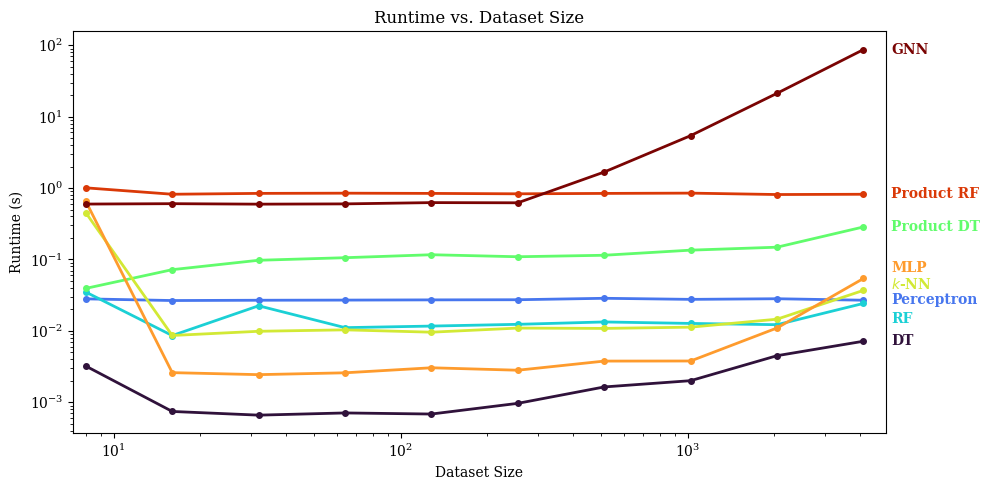

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set font to LaTeX times font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

plt.figure(figsize=(10, 5))

# Plot the bars using pandas plotting
timecols = [c for c in results.columns if "time" in c]

# Sort timecols by max time
timecols = sorted(timecols, key=lambda c: results[c].max())

# Remove tangent mlp and tangent gnn
timecols = [c for c in timecols if "tangent" not in c]

colors = plt.cm.turbo(np.linspace(0, 1, len(timecols)))

# Plot each line
lines = []
for col, color in zip(timecols, colors):
    line = plt.plot(results["size"], results[col], label=col, color=color, linewidth=2, marker="o", markersize=4)[0]
    lines.append(line)

# Set scales
plt.xscale("log")
plt.yscale("log")

# Set labels and title
plt.xlabel("Dataset Size")
plt.ylabel("Runtime (s)")
plt.title("Runtime vs. Dataset Size")

# Add right-aligned labels
xmax = results["size"].max()
for line, color, label, offset in zip(
    lines,
    colors,
    ["GNN", "Product RF", "MLP", "$k$-NN", "Product DT", "RF", "Perceptron", "DT"][::-1],
    # [1., 1., 1., 1.4, 1.2, 1., 0.75, 1.][::-1]
    [1.0, 1.0, 1.4, 1.2, 1.0, 0.6, 1.0, 1.0][::-1],
):
    # Get the last y-value for this line
    y = line.get_ydata()[-1] * offset
    # Add text label
    plt.text(xmax * 1.25, y, label, verticalalignment="center", fontsize=10, color=color, fontweight="bold")

# Extend x-axis to make room for labels
plt.xlim(results["size"].min() * 0.9, xmax * 1.2)

# Tight layout to prevent label cutoff
plt.tight_layout()
plt.savefig("embedders/figures/runtime_vs_size.pdf")

# Troubleshoot regression

My regressions don't seem very good. For instance, the CS-PhDs dataset shows an RMSE of 1975 or whatever. How can I fix this?

In [ ]:
%load_ext autoreload
%autoreload 2

import embedders
import numpy as np
import torch 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

device="cpu"

# Load CS-PhDs
_, y, adj = embedders.dataloaders.load("cs_phds")

# Get embeddings
    # ("cs_phds", "H", [(-1, 4)], "regression"

X = torch.tensor(np.load("embedders/data/graphs/embeddings/cs_phds/H_0.npy"), device=device)

pm = embedders.manifolds.ProductManifold(signature=[(-1, 4)], device=device)
mlp = embedders.predictors.mlp.MLP(pm=pm, input_dim=5, hidden_dims=[128, 128], output_dim=1, task="regression")
mlp = mlp.to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

mlp.fit(X_train, y_train, epochs=1_000)

y_pred = mlp.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse # Ok at 62.6 I'm satisfied with my hyperparameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Top CC has 1025 nodes; original graph has 1025 nodes.


62.5898237193704